<img style="float: left; margin: 30px 15px 15px 15px;" src="https://encrypted-tbn0.gstatic.com/images?q=tbn:ANd9GcTFzQj91sOlkeDFkg5HDbjtR4QJYmLXkfMNig&usqp=CAU" width="400" height="500" /> 
    
    
### <font color='navy'> Modelos no lineales para pronósticos. 

**Nombre:** José Manuel Haces López

**Fecha:** 07 de febrero del 2023.

**Expediente** : 734759
    
**Profesor:** Oscar David Jaramillo Zuluaga.
    
**Link Github**: https://github.com/anarosaura/Tarea2_ARZAMARRON_JMHACES_OAHERNANDEZ

# Tarea 2: Clase 4

## Enunciado de tarea (Transcibirlo)

Para ejemplo estudiado en esta clase data WWWUsage.csv probar lo siguiente:
1. Encontrar el mejor modelo ARIMA usando los criterios de AIC, BIC y log-verosimilud, justificando la estructura propuesta.
2. Analizar el efecto de normalizar la serie de tiempo, es decir usar MinMaxScaler para normalizar los datos. Posterior a esto, realizar el mismo precedimiento realizado en clase y encontrar el mejor modelo de ARIMA. Justifique todos los análisis realizados, incluyendo los resultados de las gráficas de ACF y PAC.
3. Investigar la implementación y teoría de los modelos SARIMAX. Además de eso, generar un modelo de pronóstico usando SARIMAX, donde todo el procediemiento anteriormente descrito es implementado, para el siguiente conjunto de datos con estacionalidad:
```
air2 = requests.get('https://www.stata-press.com/data/r12/air2.dta').content
data2 = pd.read_stata(BytesIO(air2))
data2.index = pd.date_range(start=datetime(data2.time[0], 1, 1), periods=len(data2), freq='MS')
```
**Nota**: Pueden basarse en el siguiente enlace para entender el análisis a realizar 
https://analyticsindiamag.com/complete-guide-to-sarimax-in-python-for-time-series-modeling/

4. Realizar una predicción de 20 unidades de tiempo en el futuro, tanto para el modelo ARIMA como SARIMA y reportar los resulados en una gráfica donde se puedan observar los datos reales y los datos predichos, cómo en la siguiente gráfica:
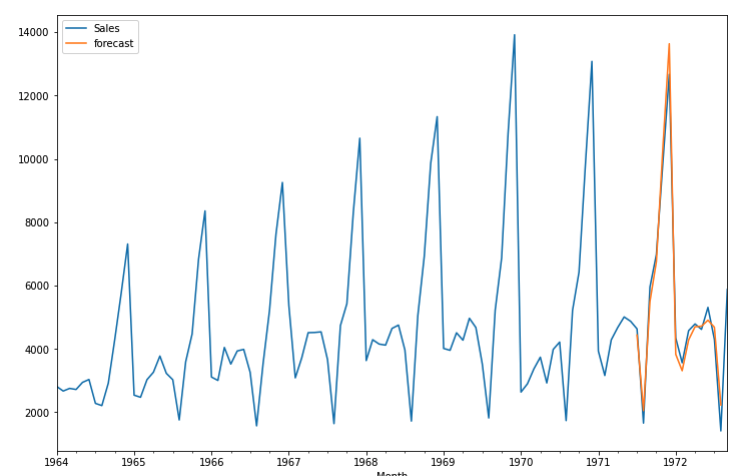


## Librerías y Funciones

In [1]:
# Librerías

import requests
import warnings
import datetime
import numpy as np
import pandas as pd
import datetime as dt
from io import BytesIO
from scipy.stats import norm
import statsmodels.api as sm
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import adfuller
from sklearn.preprocessing import MinMaxScaler
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error, mean_absolute_error

# Ignorar warnings
warnings.filterwarnings("ignore")

# Dando formato a las gráficas
plt.rc("font", size=12)

In [2]:
# Función para saber si la serie es estacionaria o no
def adf_test(timeseries):
    print("Results of Dickey-Fuller Test:")
    dftest = adfuller(timeseries, autolag="AIC")
    dfoutput = pd.Series(
        dftest[0:4],
        index=[
            "Test Statistic",
            "p-value",
            "#Lags Used",
            "Number of Observations Used",
        ],
    )
    for key, value in dftest[4].items():
        dfoutput["Critical Value (%s)" % key] = value
    print(dfoutput)
    
    if (dftest[1] <= 0.05) & (dftest[4]['5%'] > dftest[0]):
        print("\u001b[32mStationary\u001b[0m")
    else:
        print("\x1b[31mNon-stationary\x1b[0m")
        

# Función para Graficar ACF y PACF
def plot_acf_pacf(data, kwargs=dict()):
    f = plt.figure(figsize=(8,5))
    ax1 = f.add_subplot(121)
    plot_acf(data, zero=False, ax=ax1, **kwargs)
    ax2 = f.add_subplot(122)
    plot_pacf(data, zero=False, ax=ax2, method='ols', **kwargs)
    plt.show()

# Función para evaluar
def evaluate_forecasts(actual, predicted):
    mse = mean_squared_error(actual, predicted)
    rmse = mean_squared_error(actual, predicted, squared=True)
    mad = mean_absolute_error(actual, predicted)
    mape = mean_absolute_percentage_error(actual, predicted)
    # Métricas de error
    results = pd.DataFrame([mse, rmse, mad, mape]).T
    results.columns = ["mse", "rmse", "mad", "mape"]

    return results

## Carga de Datos

In [3]:
data = pd.read_csv('Dataset/WWWusage.csv', names=[ 'values'], header=0)
data.index = data.index.droplevel()
data.head()

,values
1,88
2,84
3,85
4,85
5,84


<AxesSubplot: >

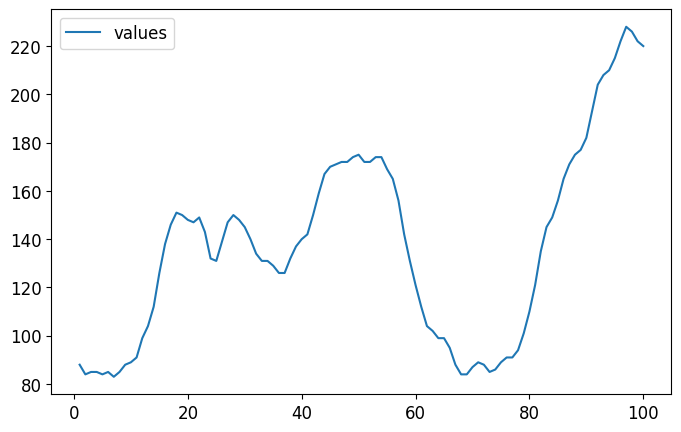

In [4]:
# Ploteando
data.plot(figsize=(8,5))

### Ejercicio 1: 
1. Encontrar el mejor modelo ARIMA usando los criterios de AIC, BIC y log-verosimilud, justificando la estructura propuesta.

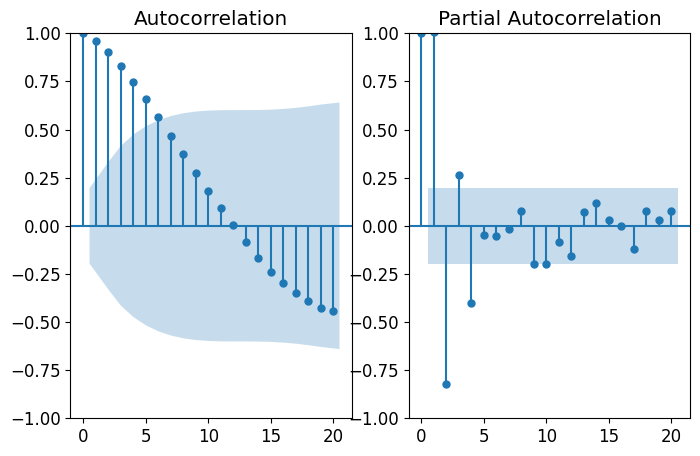

In [5]:
# 1. Graficar ACF y PACF
f = plt.figure(figsize=(8,5))

ax1 = f.add_subplot(121)
plot_acf(data, ax=ax1)

ax2 = f.add_subplot(122)
plot_pacf(data, ax=ax2, method='ols')

plt.show()

In [6]:
adf_test(data)

Results of Dickey-Fuller Test:
Test Statistic                 -2.464240
p-value                         0.124419
#Lags Used                      3.000000
Number of Observations Used    96.000000
Critical Value (1%)            -3.500379
Critical Value (5%)            -2.892152
Critical Value (10%)           -2.583100
dtype: float64
Non-stationary


- Nuestra serie no es estacionaría, por lo que la diferenciaremos e intentaremos hacerla.

In [7]:
# Haciendo una diferenciación de grado 2
diff2_values = data.diff().diff().dropna()

print('ADF para derivada segundo orden...\n')
adf_test(diff2_values)

ADF para derivada segundo orden...

Results of Dickey-Fuller Test:
Test Statistic                -9.929762e+00
p-value                        2.843429e-17
#Lags Used                     1.000000e+00
Number of Observations Used    9.600000e+01
Critical Value (1%)           -3.500379e+00
Critical Value (5%)           -2.892152e+00
Critical Value (10%)          -2.583100e+00
dtype: float64
Stationary


- Observamos que la serie es estacionaria y que el 'p-value' < 0.05, por lo que rechazamos hipótesis nula y aceptamos alternativa "La serie, sí es estacionaria"

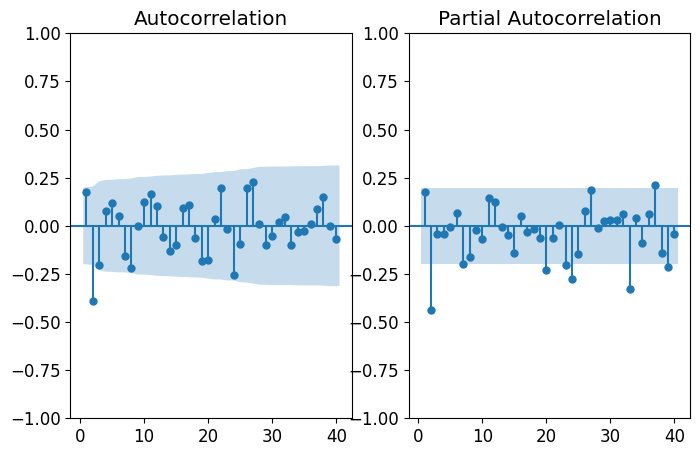

In [8]:
# Ploteando gráficas ACF y PACF con lag de 40
plot_acf_pacf(diff2_values, {'lags':40})

Basandonos en las gráficas anteriores, se deciden los valores:
- p = 2, el 2 lag está fuera de la tolerancia.
- d = 2, diferenciamos 2 veces.
- q = 1, solo hay lag fuera de la tolerancia en la autocorrelación.

In [9]:
# Modelo
model = ARIMA(data, order=(2, 2, 1))
model = model.fit()
print(model.summary())

                               SARIMAX Results                                
Dep. Variable:                 values   No. Observations:                  100
Model:                 ARIMA(2, 2, 1)   Log Likelihood                -252.628
Date:                Tue, 07 Feb 2023   AIC                            513.256
Time:                        15:22:27   BIC                            523.596
Sample:                             0   HQIC                           517.438
                                - 100                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.3513      0.236      1.488      0.137      -0.111       0.814
ar.L2         -0.4572      0.097     -4.729      0.000      -0.647      -0.268
ma.L1         -0.1162      0.254     -0.457      0.6

Notas del modelo:
- Significancia de los parámetros:
    - p: 
        - el primer lag NO es significativo.
        - el segundo lag es significativo.
    - q: 
        - el primer lag NO es significativo.
        
- Suposiciones:
    - Datos Distribuyen Manera Independiente (Ljung-Box):
        - Tenemos una probabilidad de 0.98 > 0.05, por lo que aceptamos H0. Los datos distribuyen de forma independiente.
    - Heterocedasticidad:
        - 0.49 y 0.04 de p-value, por lo que rechazamos H0. Los datos son heterocedasticos.
    - Normalidad en los errores:
        - 0.06 y p-value de 0.97 > 0.05, aceptamos H0. Los errores distribuyen de manera normal. Poco sesgo y curtosis regular.

____

<AxesSubplot: >

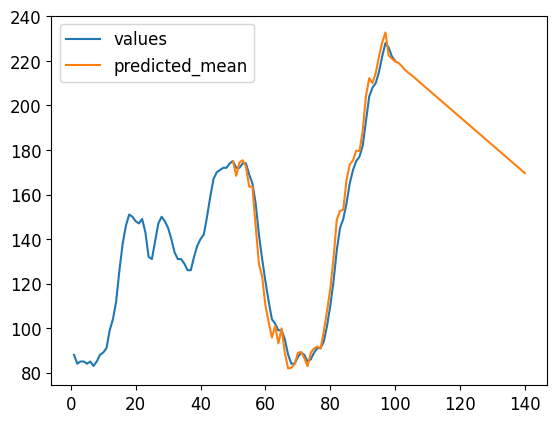

In [10]:
# Prediciendo con el modelo obtenido, hasta 40 épocas más
y_pred = model.predict(start=50, end=140, dynamic=False).to_frame()

ax = data.plot()
y_pred.plot(ax=ax)

## Ejercicio 2:
2. Analizar el efecto de normalizar la serie de tiempo, es decir usar MinMaxScaler para normalizar los datos. Posterior a esto, realizar el mismo procedimiento realizado en clase y encontrar el mejor modelo de ARIMA. Justifique todos los análisis realizados, incluyendo los resultados de las gráficas de ACF y PAC.

In [11]:
data.head()

,values
1,88
2,84
3,85
4,85
5,84


<AxesSubplot: >

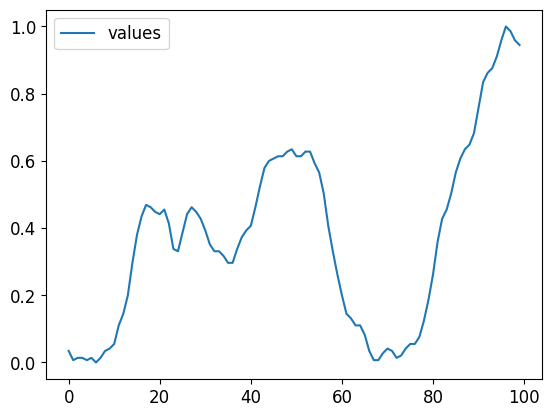

In [12]:
# Hacer el objeto scaler Min_Max
scaler = MinMaxScaler()
# Fit y transformación de los datos
scaled_data = scaler.fit_transform(data)
# Haciendo el array resultante en DF
scaled_data = pd.DataFrame(scaled_data)
# Cambiando el nombre de la columna
scaled_data.columns = ['values']

# Ploteando los datos
scaled_data.plot()

In [13]:
# Viendo si la serie es estacionaria
adf_test(scaled_data)

Results of Dickey-Fuller Test:
Test Statistic                 -2.464240
p-value                         0.124419
#Lags Used                      3.000000
Number of Observations Used    96.000000
Critical Value (1%)            -3.500379
Critical Value (5%)            -2.892152
Critical Value (10%)           -2.583100
dtype: float64
Non-stationary


- No es estacionaria, así que diferenciamos.

In [14]:
# Haciendo una diferenciación de grado
diff1_values_scaled = scaled_data.diff().dropna()
print('ADF para derivada segundo orden...\n')
adf_test(diff1_values_scaled)

print('\n\n')

# Haciendo una diferenciación de grado 2
diff2_values_scaled = scaled_data.diff().diff().dropna()
print('ADF para derivada segundo orden...\n')
adf_test(diff2_values_scaled)

ADF para derivada segundo orden...

Results of Dickey-Fuller Test:
Test Statistic                 -2.722238
p-value                         0.070268
#Lags Used                      2.000000
Number of Observations Used    96.000000
Critical Value (1%)            -3.500379
Critical Value (5%)            -2.892152
Critical Value (10%)           -2.583100
dtype: float64
Non-stationary



ADF para derivada segundo orden...

Results of Dickey-Fuller Test:
Test Statistic                -9.929762e+00
p-value                        2.843429e-17
#Lags Used                     1.000000e+00
Number of Observations Used    9.600000e+01
Critical Value (1%)           -3.500379e+00
Critical Value (5%)           -2.892152e+00
Critical Value (10%)          -2.583100e+00
dtype: float64
Stationary


- Al final se decide tomar las dos diferenciaciones, aunque se pudiera con 1 ya que el p-values es muy cercano a 0.05, sin embargo prefiero tomar 2 diferenciaciones.

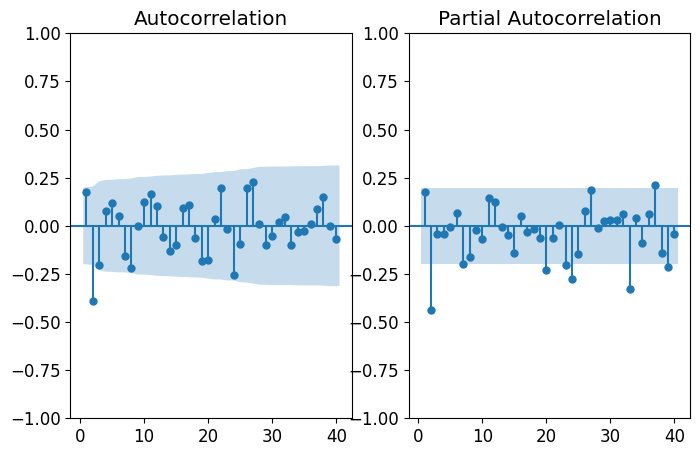

In [15]:
# Ploteando gráficas ACF y PACF con lag de 40
plot_acf_pacf(diff2_values, {'lags':40})

Basandonos en las gráficas anteriores, se deciden los valores:
- p = 2, el 2° lag está fuera de la tolerancia.
- d = 2, diferenciamos 2 veces.
- q = 1, solo hay un lag fuera de la tolerancia en la autocorrelación.

In [16]:
# Modelo
model = ARIMA(scaled_data, order=(2, 2, 1))
model = model.fit()
print(model.summary())

                               SARIMAX Results                                
Dep. Variable:                 values   No. Observations:                  100
Model:                 ARIMA(2, 2, 1)   Log Likelihood                 235.091
Date:                Tue, 07 Feb 2023   AIC                           -462.182
Time:                        15:22:28   BIC                           -451.842
Sample:                             0   HQIC                          -458.000
                                - 100                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.3416      0.236      1.445      0.148      -0.122       0.805
ar.L2         -0.4544      0.097     -4.693      0.000      -0.644      -0.265
ma.L1         -0.1049      0.255     -0.412      0.6

Notas del modelo:
- Significancia de los parámetros:
    - p: 
        - el primer lag NO es significativo.
        - el segundo lag es significativo.
    - q: 
        - el primer lag NO es significativo.
        
- Suposiciones:
    - Datos Distribuyen Manera Independiente (Ljung-Box):
        - Tenemos una probabilidad de 0.97 > 0.05, por lo que aceptamos H0. Los datos distribuyen de forma independiente.
    - Heterocedasticidad:
        - 0.49 y 0.04 de p-value, por lo que rechazamos H0. Los datos son heterocedasticos.
    - Normalidad en los errores:
        - 0.06 y p-value de 0.97 > 0.05, aceptamos H0. Los errores distribuyen de manera normal. Muy poco sesgo y curtosis regular.

### Resultados ejercicio 2:
- La normalización MinMaxScaler, no ayudó en mucho, ya que tenemos casi los mismos resultados. Esto puede ser debido a que seguiimos con la misma curva en los datos y no suavizamos nada de los datos, simplemente redujimos las magnitudes de los valores.

____

## Ejericio 3:
3. Investigar la implementación y teoría de los modelos SARIMAX. Además de eso, generar un modelo de pronóstico usando SARIMAX, donde todo el procediemiento anteriormente descrito es implementado, para el siguiente conjunto de datos con estacionalidad:
```
air2 = requests.get('https://www.stata-press.com/data/r12/air2.dta').content
data2 = pd.read_stata(BytesIO(air2))
data2.index = pd.date_range(start=datetime(data2.time[0], 1, 1), periods=len(data2), freq='MS')
```
**Nota**: Pueden basarse en el siguiente enlace para entender el análisis a realizar 
https://analyticsindiamag.com/complete-guide-to-sarimax-in-python-for-time-series-modeling/

In [17]:
air2 = requests.get('https://www.stata-press.com/data/r12/air2.dta').content
data2 = pd.read_stata(BytesIO(air2))
data2.index = pd.date_range(start=dt.datetime(int(data2.time[0]), 1, 1), periods=len(data2), freq='MS') # month start frequency

# Nos quedamos con la variable que queremos
data2.drop(columns=['time', 't'], inplace=True)

data2.head()

,air
1949-01-01,112
1949-02-01,118
1949-03-01,132
1949-04-01,129
1949-05-01,121


<AxesSubplot: >

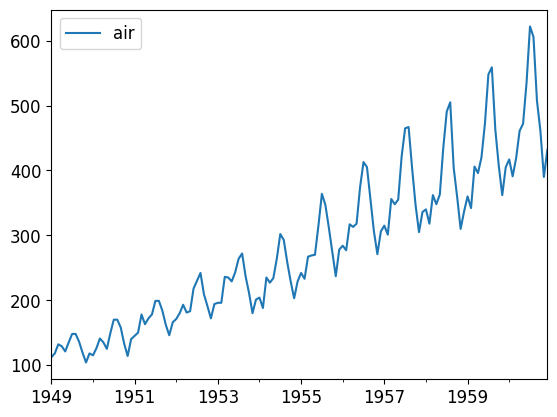

In [18]:
# Ploteando
data2.plot()

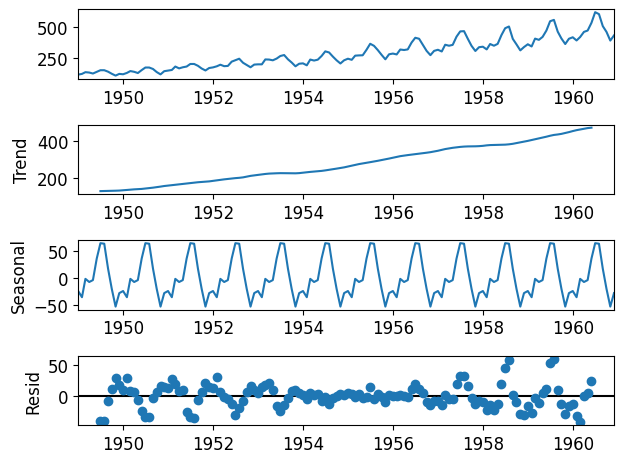

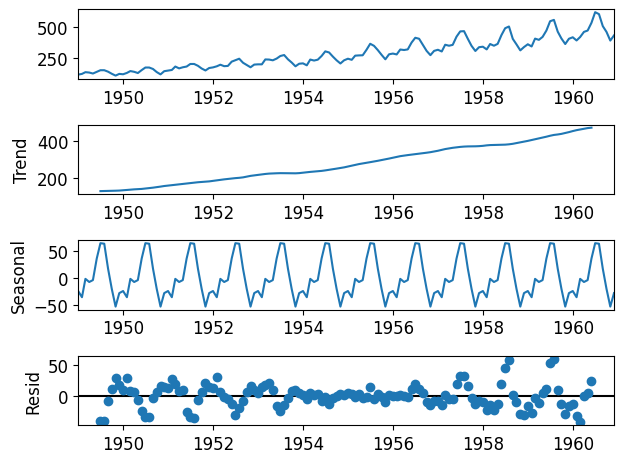

In [19]:
# Estacionalidad de la serie de tiempo (anual)
decompose_data = seasonal_decompose(data2, model="additive", period=12)
decompose_data.plot()

- Tenemos una tendencia a la alta
- Tenemos una estacionalidad bastante marcada
- Los residuos parece que no distribuyen del todo de manera aleatoria, parece que sigue una tendencia. Parecen ser heterocedasticos.

In [20]:
adf_test(data2)

Results of Dickey-Fuller Test:
Test Statistic                   0.815369
p-value                          0.991880
#Lags Used                      13.000000
Number of Observations Used    130.000000
Critical Value (1%)             -3.481682
Critical Value (5%)             -2.884042
Critical Value (10%)            -2.578770
dtype: float64
Non-stationary


- Tenemos un valor de p-value de casi 100% de probabilidad.

<AxesSubplot: >

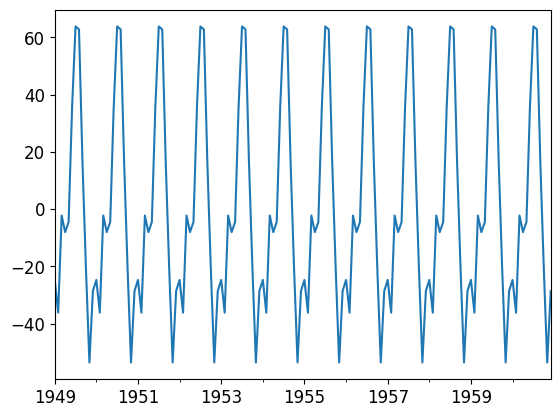

In [21]:
# Estacionalidad
estacionalidad = decompose_data.seasonal
estacionalidad.plot()

- El artículo menciona que teniendo una estacionalidad muy marcada, se diferencia con media movil para acercarnos mal a algo desestacionalizado.

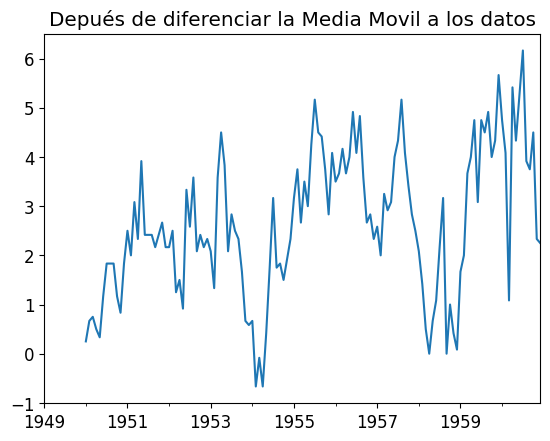

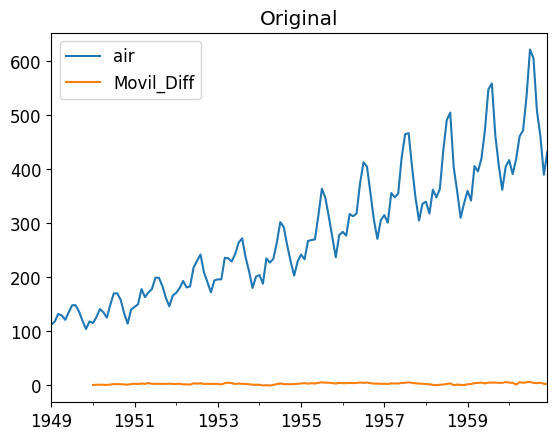

In [22]:
# Obteniendo la media movil con ventana de 12 anual
rolling_mean = data2.rolling(window = 12).mean()
# restando
data2['Movil_Diff'] = rolling_mean - rolling_mean.shift()
# Haciendo la gráfica
ax1 = plt.subplot()
data2['Movil_Diff'].plot(title='Depués de diferenciar la Media Movil a los datos');

ax2 = plt.subplot()
data2.plot(title='Original');

In [23]:
# Quitando los nulos
data_est = data2.dropna()
data_est.drop(columns='air', inplace=True)
data_est.head()

,Movil_Diff
1950-01-01,0.250000
1950-02-01,0.666667
1950-03-01,0.750000
1950-04-01,0.500000
1950-05-01,0.333333


- Gracias a restar la media movil, podemos ver que los datos pierden la estacionalidad de una gran manera (gráfica de arriba).

In [24]:
# Veamos si la serie ya es estacionaria
adf_test(data_est)

Results of Dickey-Fuller Test:
Test Statistic                  -3.383021
p-value                          0.011551
#Lags Used                       1.000000
Number of Observations Used    130.000000
Critical Value (1%)             -3.481682
Critical Value (5%)             -2.884042
Critical Value (10%)            -2.578770
dtype: float64
Stationary


- Después de diferenciar con la Media Movil la serie se ha vuelto estacionaria.

In [25]:
# División en train y test al 80% de los datos
train, test = np.split(data2, [int(.80 * len(data2))])
train

,air,Movil_Diff
1949-01-01,112,NaN
1949-02-01,118,NaN
1949-03-01,132,NaN
1949-04-01,129,NaN
1949-05-01,121,NaN
...,...,...
1958-03-01,362,0.500000
1958-04-01,348,0.000000
1958-05-01,363,0.666667
1958-06-01,435,1.083333


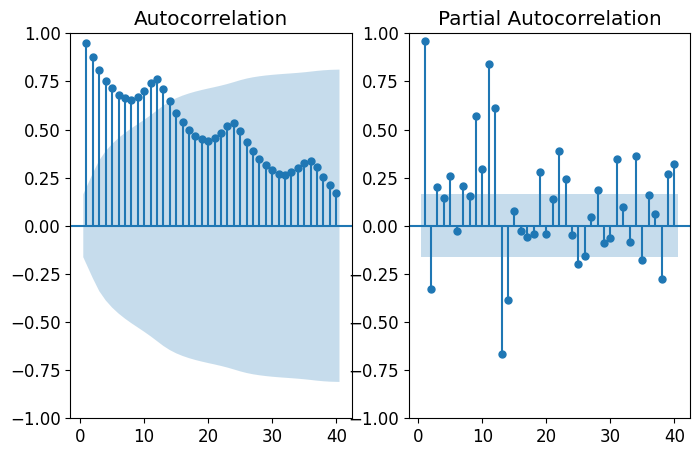

In [26]:
# Ploteando gráficas ACF y PACF con lag de 40
# Datos normales
plot_acf_pacf(data2['air'], {'lags':40})

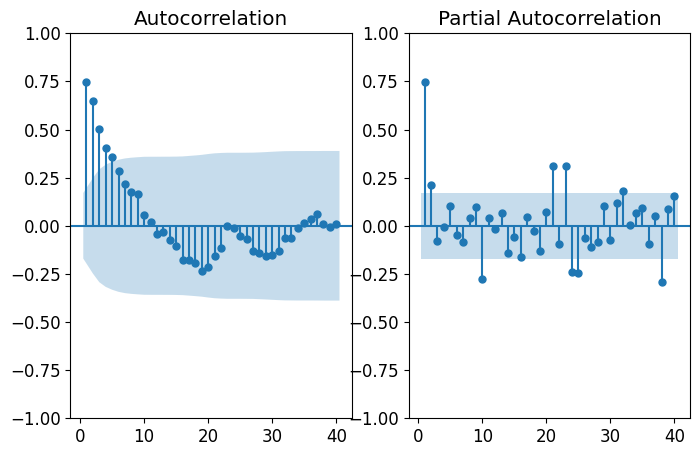

In [27]:
# Ploteando gráficas ACF y PACF con lag de 40
# Datos desestacionalizados
plot_acf_pacf(data_est, {'lags':40})

### Arima

In [28]:
# Modelo
model = ARIMA(train['air'], order=(2, 2, 1))
model = model.fit()
print(model.summary())

                               SARIMAX Results                                
Dep. Variable:                    air   No. Observations:                  115
Model:                 ARIMA(2, 2, 1)   Log Likelihood                -527.196
Date:                Tue, 07 Feb 2023   AIC                           1062.393
Time:                        15:22:32   BIC                           1073.302
Sample:                    01-01-1949   HQIC                          1066.820
                         - 07-01-1958                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.3397      0.092      3.706      0.000       0.160       0.519
ar.L2         -0.2108      0.105     -2.001      0.045      -0.417      -0.004
ma.L1         -0.9999     18.919     -0.053      0.9

<AxesSubplot: >

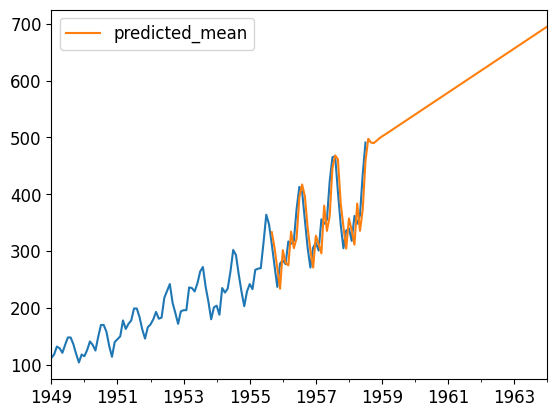

In [29]:
# Prediciendo con el modelo obtenido, hasta 40 épocas más
y_pred = model.predict(start=80, end=180, dynamic=False).to_frame()

ax = train['air'].dropna().plot()
y_pred.plot(ax=ax)

### Saarimax

<AxesSubplot: >

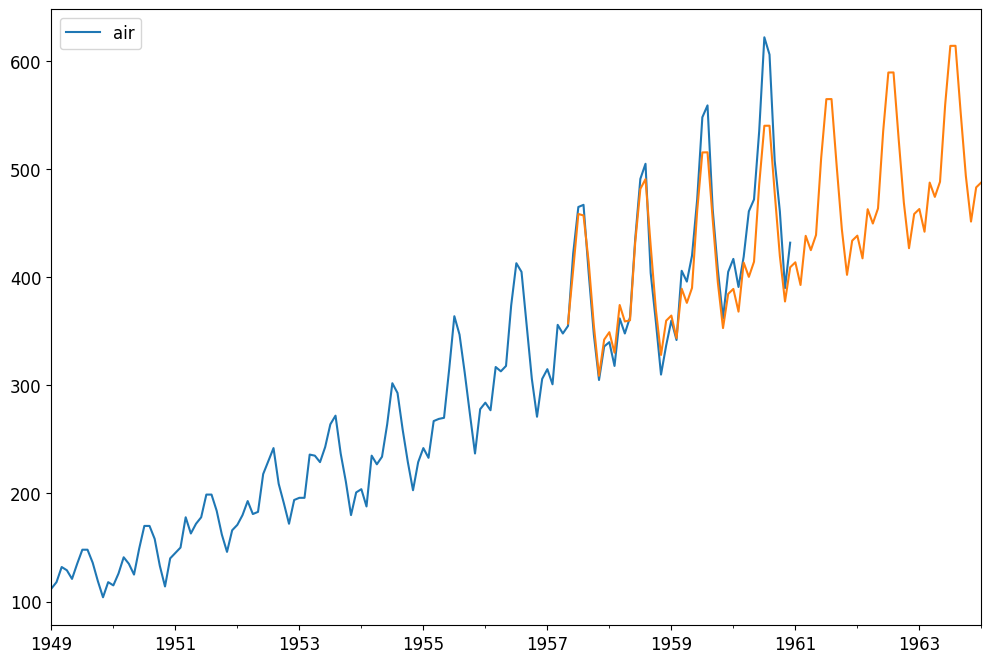

In [30]:
# Modelo 2: con los datos de la diferenciación
model_sarimax = sm.tsa.statespace.SARIMAX(train['air'], order=(1, 1, 5), seasonal_order=(1, 1, 1, 12))
results = model_sarimax.fit()

forecast = results.predict(start=100,end=180)
data2[['air']].plot(figsize=(12,8))
forecast.plot()

____

## Ejercicio 4:
4. Realizar una predicción de 20 unidades de tiempo en el futuro, tanto para el modelo ARIMA como SARIMA y reportar los resulados en una gráfica donde se puedan observar los datos reales y los datos predichos.

<AxesSubplot: >

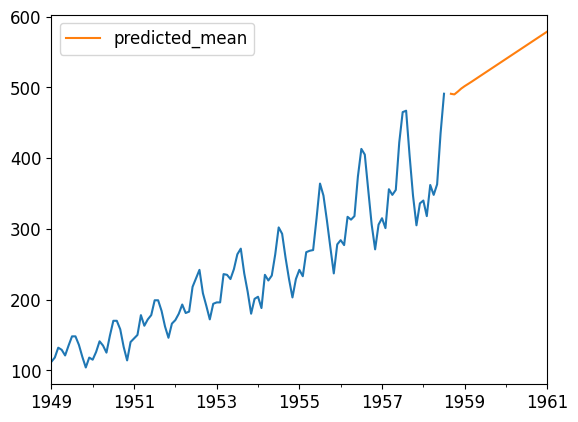

In [31]:
# ARIMA
y_pred = model.predict(start=116, end=144, dynamic=False).to_frame()

ax = train['air'].dropna().plot()
y_pred.plot(ax=ax)

In [32]:
# Evaluando el modelo
evaluate_forecasts(test['air'], y_pred)

,mse,rmse,mad,mape
0,13661.86832,13661.86832,105.12277,0.263786


<AxesSubplot: >

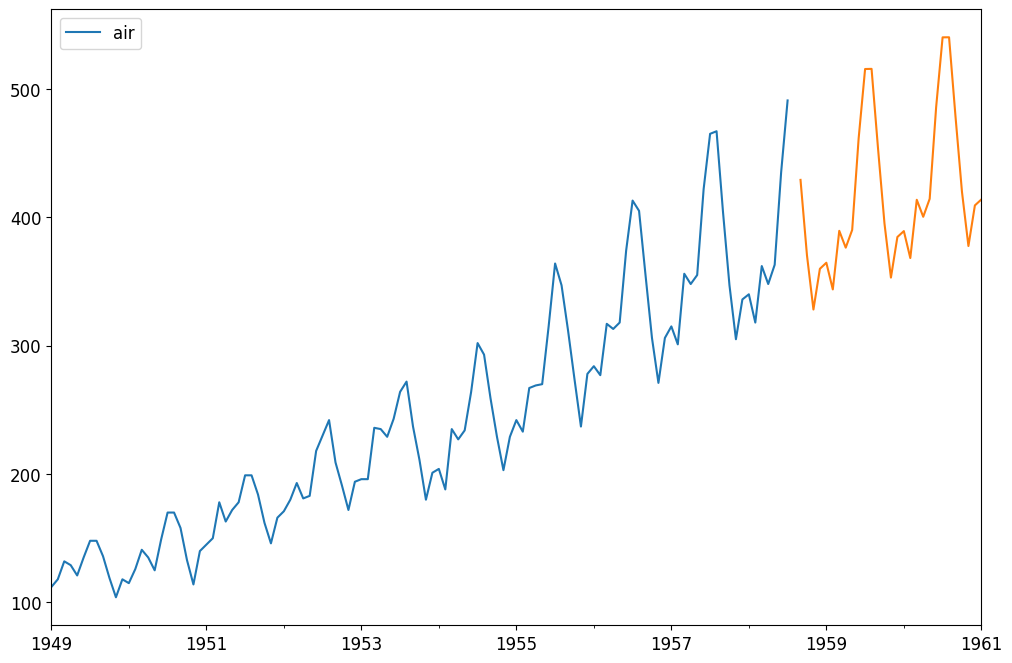

In [33]:
# SARIMAX
forecast = results.predict(start=116, end=144)
train[['air']].plot(figsize=(12,8))
forecast.plot()

In [34]:
# Evaluando el modelo
evaluate_forecasts(test['air'], forecast)

,mse,rmse,mad,mape
0,2847.072616,2847.072616,43.920774,0.096539


### Conclusiones
- El modelo Sarimax nos da un mejor resultado en este caso, ya que la serie de tiempo tiene mucha estacionalidad, por lo que un modelo que incorpore estacionalidad nos va a dar mejores resultados. El modelo nos dio los errores más pequeños, por lo que para esta serie seleccionaremos este modelo (SARIMAX)